In [120]:
import numpy as np
import os
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from keras import layers,models
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
import pandas as pd
import matplotlib.pyplot as plt

In [121]:

test_path = "test"
images = os.listdir(test_path)

In [122]:
def calculate_psnr(img1, img2):

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    min_val = np.min((img1, img2))
    max_val = np.max((img1, img2))
    data_range = max_val - min_val  

    min_size = min(img1.shape)
    win_size = min(7, min_size)  

    return ssim(img1, img2, win_size=win_size, data_range=data_range)

In [123]:
def show_images_2i(original_image,improved_image,title):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(improved_image, cmap='gray') 
    plt.title(title)

    plt.show()

def show_images_3i(original_image,improved_image,improved_image2,title,title2):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(improved_image, cmap='gray') 
    plt.title(title)
    
    plt.subplot(1, 3, 3)
    plt.imshow(improved_image2, cmap='gray') 
    plt.title(title2)


    plt.show()

TEMEL YÖNTEMLER: CLAHE

In [124]:
def apply_clahe():
    results = []
    
    output_path ="clahe_output"
    os.makedirs(output_path, exist_ok=True)    

    for img in images:
        img_path = os.path.join(test_path,img)
        original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(original_img)
        
        img_name, img_extension = os.path.splitext(os.path.basename(img_path))
        output_img_path = os.path.join(output_path,f"clahe_"+img_name+".png")
        cv2.imwrite(output_img_path,clahe_image)
    
        psnr_value = calculate_psnr(original_img, clahe_image)
        ssim_value = calculate_ssim(original_img, clahe_image)

        result = {'Image': img, 'PSNR': psnr_value, 'SSIM': ssim_value}
        results.append(result)

        # cv2.imshow("Original",original_img)  
        # cv2.imshow("Clahe Enhanced",clahe_image)
        
        show_images_2i(original_img,clahe_image,"Clahe")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return pd.DataFrame(results)


TEMEL YÖNTEMLER: RETINEX

In [125]:
def single_scale_retinex(image, sigma):
    blurred_image = cv2.GaussianBlur(image, (0, 0), sigma)
    retinex = np.log(image) - np.log(blurred_image)
    return np.float32(retinex)        

def multi_scale_retinex(image, scales):
    retinex = np.zeros_like(image, dtype=np.float32)
    for scale in scales:
        retinex += single_scale_retinex(image, scale)
    retinex /= len(scales)
    return np.float32(retinex)   

def apply_retinex():
    ssr_results = []
    msr_results = []
    
    output_path = "retinex_output"
    os.makedirs(output_path, exist_ok=True)    
    
    ssr_output_path = os.path.join(output_path,"ssr")
    os.makedirs(ssr_output_path, exist_ok=True)    
    msr_output_path = os.path.join(output_path,"msr")
    os.makedirs(msr_output_path, exist_ok=True)

    for img in images:
        img_path = os.path.join(test_path,img)
        original_image = cv2.imread(img_path)
        original_image = original_image.astype(np.float32) / 255.0

        #Single Scale Retinex
        sigma_ssr = 50
        ssr_result = single_scale_retinex(original_image, sigma_ssr)

        # Multi Scale Retinex
        scales_msr = [15, 80, 250]
        msr_result = multi_scale_retinex(original_image, scales_msr)
        
        show_images_3i(original_image,ssr_result,msr_result,"SSR","MSR")
        img_name, img_extension = os.path.splitext(os.path.basename(img_path))
        
        ssr_img_path = os.path.join(ssr_output_path,f"ssr_"+img_name+".png")
        msr_img_path = os.path.join(msr_output_path,f"msr_"+img_name+".png")
        
        

        cv2.imwrite(ssr_img_path,ssr_result)
        cv2.imwrite(msr_img_path,msr_result)
        
        # SSR İçin PSNR ve SSIM hesapla
        ssr_psnr_value = calculate_psnr(original_image, ssr_result)
        ssr_ssim_value = calculate_ssim(original_image, ssr_result)

        ssr_result = {'Image': img, 'PSNR': ssr_psnr_value, 'SSIM': ssr_ssim_value}
        ssr_results.append(ssr_results)
        
        #MSR İçin PSNR ve SSIM hesapla
        msr_psnr_value = calculate_psnr(original_image, msr_result)
        msr_ssim_value = calculate_ssim(original_image, msr_result)

        msr_result = {'Image': img, 'PSNR': msr_psnr_value, 'SSIM': msr_ssim_value}
        msr_results.append(msr_result)

        # cv2.imshow('Original Image', original_image)
        # cv2.imshow('Single Scale Retinex', ssr_result)
        # cv2.imshow('Multi Scale Retinex', msr_result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return ssr_result,msr_result, pd.DataFrame(ssr_results),pd.DataFrame(msr_results)

In [126]:

def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

def train_model(images, masks, epochs=10):
    model = unet_model()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(images, masks, epochs=epochs, batch_size=32, validation_split=0.2)

    return model

def load_images_from_folder(folder_path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size) 
            images.append(img)
    return images


def apply_unet(test_images):
    
    masks = np.random.randint(2, size=(len(test_images), 256, 256, 1)) #TODO Düzeltilecek

    trained_model = train_model(np.array(test_images), masks)

    improved_images = trained_model.predict(np.array(test_images))

    for i in range(len(test_images)):
        original_image = test_images[i]
        improved_image = improved_images[i].reshape((256, 256))  
        
        show_images_2i(original_image,improved_image,"U-NET")
    
    

   

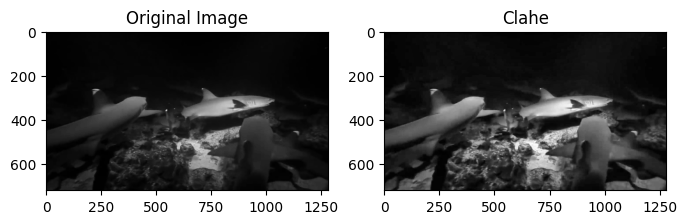

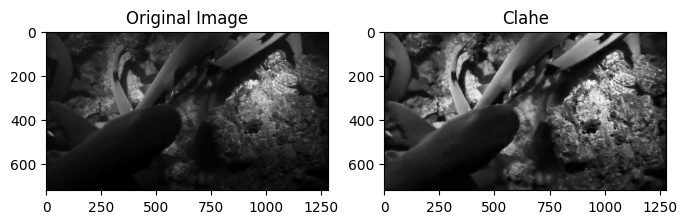

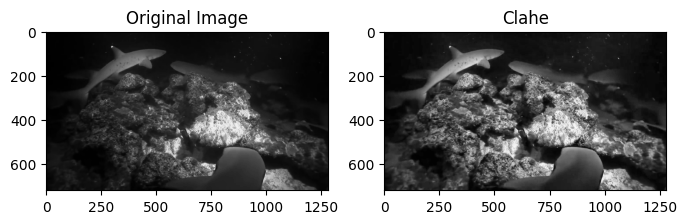

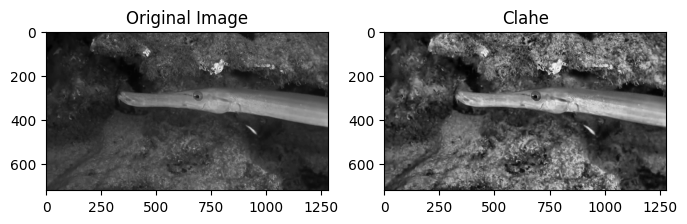

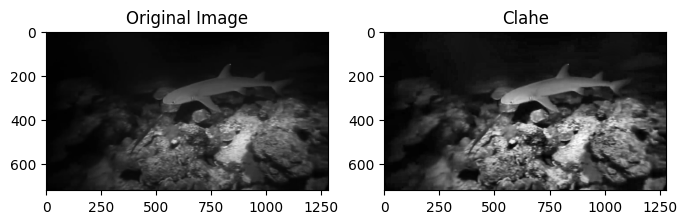

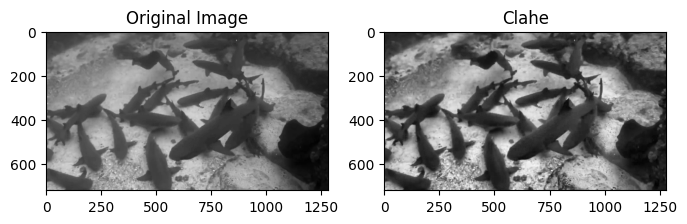

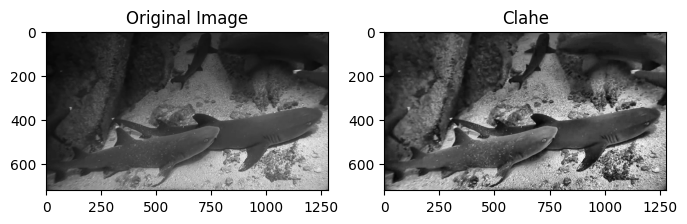

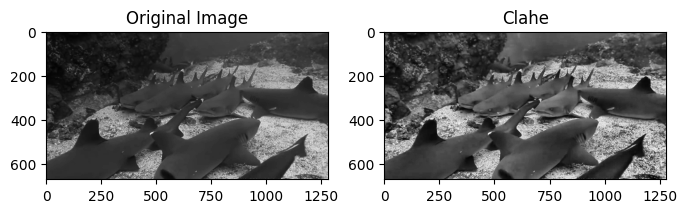

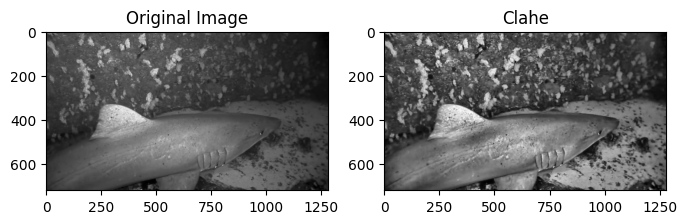

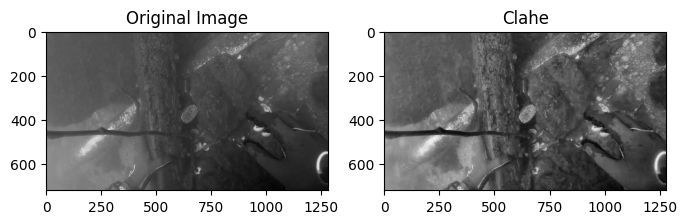

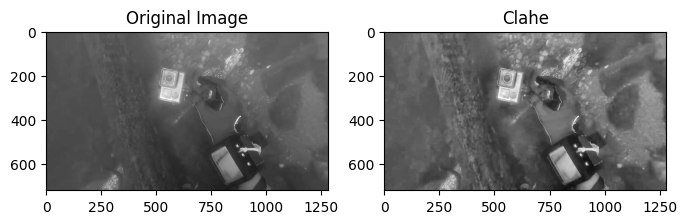

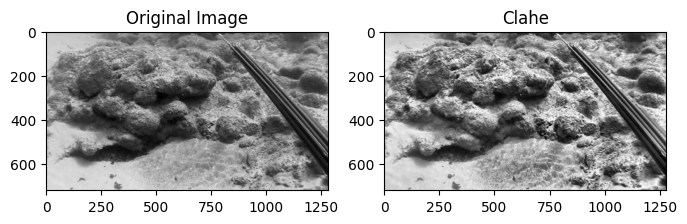

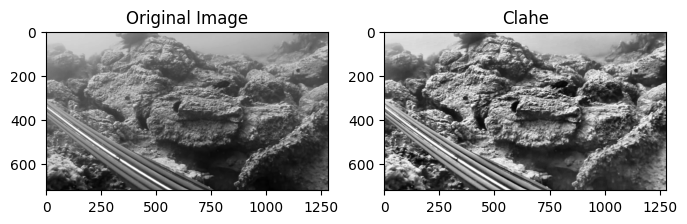

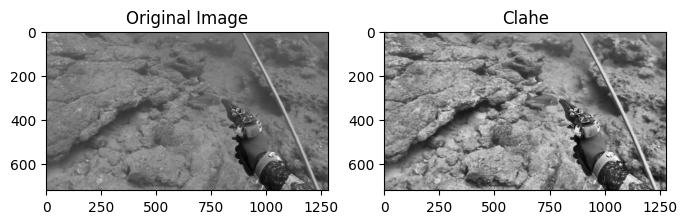

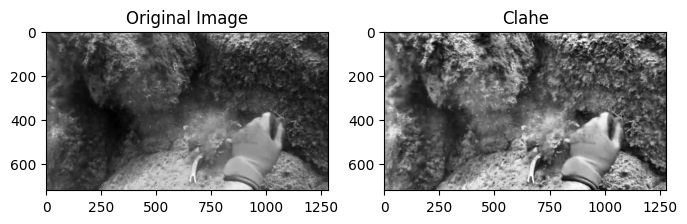

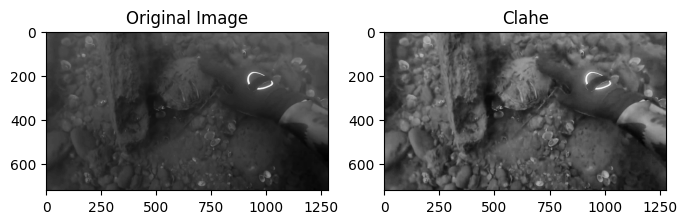

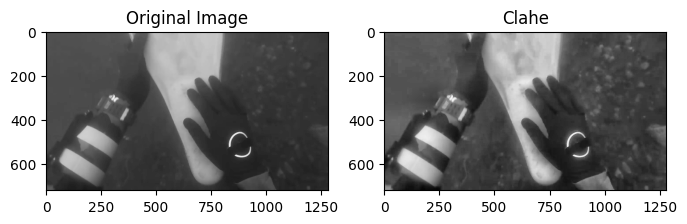

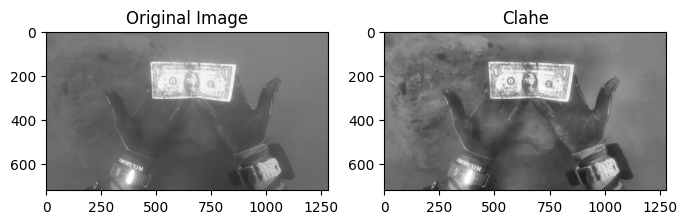

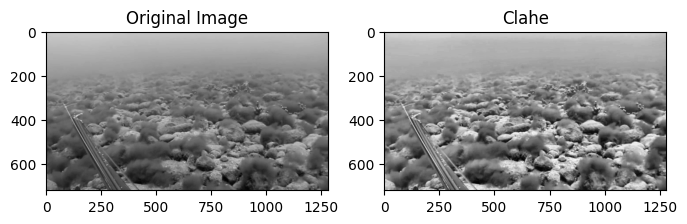

,Image,PSNR,SSIM
0,12290.png,28.950035,0.720534
1,12299.png,28.155619,0.760115
2,12324.png,28.541550,0.778112
3,12336.png,28.104904,0.799549
4,12348.png,28.582222,0.758470
5,12422.png,28.432005,0.862822
6,12433.png,28.334028,0.851598
7,12445.png,28.549124,0.875829
8,12900.png,28.461912,0.831867
9,15001.png,29.823047,0.895663


In [127]:
clahe_images = load_images_from_folder(os.path.join("clahe_output"))
retinex_ssr_images = load_images_from_folder(os.path.join("retinex_output","ssr"))
retinex_msr_images = load_images_from_folder(os.path.join("retinex_output","msr"))
original_images = load_images_from_folder(test_path)

apply_clahe()